# Reading Prism and Storm models using Stormpy

Let's first create some model in the [PRISM language]. The encoding of Consumption MDPs is done as a standard `mdp` model with two additional requirements.

 1. The consumption of actions is given by a reward structure called `consumption`. This reward structure has to assign some consumption to each action (choice).
 2. The set of reload states must be specified using the `reload` state label.
 
Note that such encoding **does not** produce model with the same semantics in PRISM and other tools.

Further, we allow to define the targets using the `target` label and capacity using the `capacity` constant in the prism model.
 
See the bottom of the following file.

[PRISM language]: https://www.prismmodelchecker.org/manual/ThePRISMLanguage/Introduction

In [1]:
%%writefile gw.prism
mdp

const int size_x = 10;
const int size_y = 10;
const int border_x = size_x-1;
const int border_y = size_y-1;

const double succ_p = 0.9;
const double fail_left_p = 0.04;
const double fail_right_p = 0.06;

// Conditions for hitting walls — robot
formula wall_north = (y = border_y);
formula wall_east = (x = border_x); 
formula wall_south = (y = 0);
formula wall_west = (x = 0);

module robot
  x : [0..size_x-1] init 0;
  y : [0..size_y-1] init 0;

  [strong_north] !wall_north -> (y'=y+1);
  [north] !wall_north & !wall_east & !wall_west -> 
	succ_p: (y'=y+1) + 
	fail_left_p: (y'=y+1)&(x'=x-1) + 
	fail_right_p: (y'=y+1)&(x'=x+1);
  [north] !wall_north &  wall_east & !wall_west -> 
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x-1); 
  [north] !wall_north & !wall_east &  wall_west -> 
	succ_p: (y'=y+1) + 
	1-succ_p: (y'=y+1)&(x'=x+1);

  [strong_south] !wall_south -> (y'=y-1);
  [south] !wall_south & !wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	fail_left_p: (y'=y-1)&(x'=x-1) + 
	fail_right_p: (y'=y-1)&(x'=x+1);
  [south] !wall_south &  wall_east & !wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x-1); 
  [south] !wall_south & !wall_east &  wall_west -> 
	succ_p: (y'=y-1) + 
	1-succ_p: (y'=y-1)&(x'=x+1); 

  [strong_east] !wall_east -> (x'=x+1);
  [east] !wall_east & !wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	fail_left_p: (x'=x+1)&(y'=y-1) + 
	fail_right_p: (x'=x+1)&(y'=y+1);
  [east] !wall_east &  wall_north & !wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y-1); 
  [east] !wall_east & !wall_north &  wall_south -> 
	succ_p: (x'=x+1) + 
	1-succ_p: (x'=x+1)&(y'=y+1); 

  [strong_west] !wall_west -> (x'=x-1);
  [west] !wall_west & !wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	fail_left_p: (x'=x-1)&(y'=y-1) + 
	fail_right_p: (x'=x-1)&(y'=y+1);
  [west] !wall_west &  wall_north & !wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y-1); 
  [west] !wall_west & !wall_north &  wall_south -> 
	succ_p: (x'=x-1) + 
	1-succ_p: (x'=x-1)&(y'=y+1); 

endmodule

rewards "consumption"
	[north] true : 1;
	[south] true : 1;
	[east] true : 1;
	[west] true : 1;
	[strong_north] true : 3;
	[strong_south] true : 3;
	[strong_east] true : 3;
	[strong_west] true : 3;
endrewards

label "reload" = (x=round(border_x/2) & y=round(border_y/2));
label "target" = (x=border_x & y=2);
const int capacity = 2 * size_x;

Overwriting gw.prism


We can get a consumption MDP right from the model using the `prism_to_consmdp` function.

In [2]:
from fimdp.io import prism_to_consmdp
mdp = prism_to_consmdp("gw.prism")
print(mdp.num_states)

100


By default, this functions keeps the action names and stores the variable valuations in state names.

In [3]:
print(mdp.names[15])
print(mdp.actions[mdp.succ[15]])
print(mdp.names[13])

15: x=3 y=0
15——strong_north[3]——>{13: Decimal('1')}
13: x=3 y=1


Names of states can be discarded by setting `state_valuations=False` and action labels can be discarded by `action_labels=False`

In [4]:
pure_mdp = prism_to_consmdp("gw.prism", 
                            state_valuations=False,
                            action_labels=False)
print(pure_mdp.names[15])
print(pure_mdp.actions[mdp.succ[15]])
print(pure_mdp.names[13])

None
15——106[3]——>{13: Decimal('1')}
None


### Targets and capacity

In our example, we have defined the targets and capacity we want to use in our analysis. We can read the targets by passing `return_targets=True` to the `prism_to_consmdp` function, and we can read the capacity using the function `parse_cap_from_prism`.

In [5]:
from fimdp.io import parse_cap_from_prism
from fimdp.energy_solvers import BasicES
from fimdp.objectives import BUCHI

mdp, targets = prism_to_consmdp("gw.prism", return_targets=True)
capacity = parse_cap_from_prism("gw.prism")
print(targets)
print(capacity)
solver = BasicES(mdp, capacity, targets)
print(solver.get_min_levels(BUCHI))

[98]
20
[20, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 15, 12, 17, 15, 17, 16, 15, 12, 9, 6, 12, 9, 16, 15, 15, 12, 9, 6, 3, 0, 6, 3, 12, 9, 15, 16, 15, 12, 9, 6, 3, 6, 6, 3, 12, 9, 16, 15, 17, 16, 15, 12, 9, 6, 9, 12, 6, 9, 12, 9, 16, 15, 17, 17, 16, 15, 14, 12, 9, 12, 14, 15, 12, 14, 12, 9, 15, 14, 17, 16, 17, 16, 15, 14, 13, 12, 13, 14, 15, 16, 14, 15, 12, 13, 14, 13, 16, 15, 17]


## Stormpy models

FiMDP also offers `storm_sparsemdp_to_consmdp` which translates a stormpy sparse representation of MDP (satisfying the same requirements as for PRISM) into Consumption MDP. It also offers `consmdp_to_storm_consmdp` which encodes the FiMDP representation into SparseMDP from Storm. This encoding is exactly such that it can be used to build the ConsMDP object back.

In [6]:
from fimdp.io import consmdp_to_storm_consmdp, storm_sparsemdp_to_consmdp
from fimdp.examples.reachability_examples import little_alsure
from fimdp.dot import dot_to_svg
from IPython.display import SVG
import stormpy

def display_storm(sparseMDP):
    return SVG(dot_to_svg(sparseMDP.to_dot()))

In [7]:
m, T = little_alsure()
storm = consmdp_to_storm_consmdp(m)

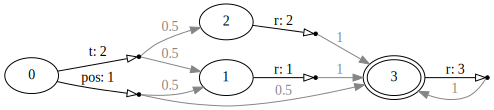

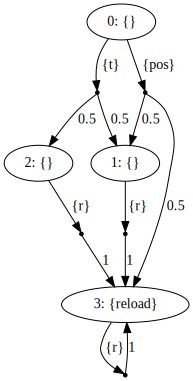

In [8]:
display(m, display_storm(storm))

We can also encode the target states.

{1, 2}


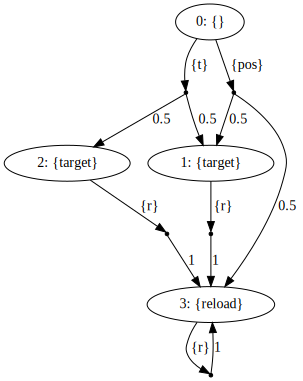

In [12]:
print(T)
display_storm(consmdp_to_storm_consmdp(m, T))

Let's see if the conversion back works as expected.

In [13]:
m.get_dot() == storm_sparsemdp_to_consmdp(storm).get_dot()

True

Analogously to the PRISM models, we can also read the target states back from the Storm's representation of ConsMDPs.

In [22]:
st_targets = consmdp_to_storm_consmdp(m, T)
mdp, st_T = storm_sparsemdp_to_consmdp(st_targets, return_targets=True)
set(st_T) == T

True